<a href="https://colab.research.google.com/github/Nilanshrajput/Vqa_detr/blob/master/DETR_Vqa_pytlightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  22680      0 --:--:-- --:--:-- --:--:-- 22560
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Uninstalling torch-1.5.0+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 89.7 MiB/ 89.7 MiB]                                                
Operation completed over 1 objects/89.7 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][117.4 MiB/117.4 MiB]                                                
Operation completed over 1 objects/117.4 MiB.         

In [3]:
!pip install transformers
!pip install pytorch-lightning

     |████████████████████████████████| 675kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 64kB/s 
     |████████████████████████████████| 890kB 25.0MB/s 
     |████████████████████████████████| 3.8MB 34.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8f2acee131f11b4eb947ef8887e16f985c76dc5f027e101055d02a120ffbcd7a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 256kB 3.3MB/s 
     |████████████████████████████████| 829kB 10.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=5e39aa46b2734b5e9267a03b226b3dbdac5188c0bbf3892c42926c8fa2de6cfa
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      S

In [0]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import json

import torch
import torch.utils.data as data
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import os
import json
import tqdm

import logging
from argparse import Namespace

from functools import lru_cache

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from transformers.tokenization_bert import BertTokenizer
from transformers import BertConfig, EncoderDecoderConfig, EncoderDecoderModel, BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import torchtext

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer



import pdb
import os

## DETR
Here is a minimal implementation of DETR:

In [0]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP) nj
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        bb_ot = h
        
        # construct positional encodings
        """        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)"""

        bs,_,H, W = h.shape
        pos = torch.cat([
        self.col_embed[:W].unsqueeze(0).unsqueeze(1).repeat(bs,H, 1, 1),
        self.row_embed[:H].unsqueeze(0).unsqueeze(2).repeat(bs,1, W, 1),
        ], dim=-1).flatten(1, 2)


        #print(self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1))
        # propagate through the transformer
        #shape changed to (W*H,bs,hidden_dim) for both pos and h
        h = self.transformer(pos.permute(1, 0, 2) + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1).repeat(1,bs,1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid(),
                'decoder_out':h,
                'res_out':bb_ot}

In [0]:
class VQA_DETR(LightningModule):
    def __init__(self,hparams,vqa_dataset, num_ans,hidden_size=256, num_attention_heads = 8, num_hidden_layers = 6):
        super().__init__()

        self.hparams = hparams
        self.vqa_dataset = vqa_dataset

        self.bert__decoder_config = BertConfig(is_decoder = True,hidden_size=hidden_size, num_attention_heads=num_attention_heads, num_hidden_layers=num_hidden_layers)
        #self.enc_dec_config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder_config= self.bert_config, decoder_config= self.bert_config)
        #self.model = EncoderDecoderModel(config= self.enc_dec_config)
        self.bert_decoder = BertModel(config=self.bert__decoder_config)

        self.detr = DETRdemo(num_classes=91)
        state_dict = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
            map_location='cpu', check_hash=True)
        self.detr.load_state_dict(state_dict)
        #self.detr  = self.detr.cuda()

        self.classifier  = nn.Linear(hidden_size*2,num_ans)

        self.drop_out = nn.Dropout(p=0.2)
        self.log_softmax = nn.LogSoftmax().cuda()
        

    def forward(self,img, q_ids):
        
        img_ecs = self.detr(img)['decoder_out'].flatten(2)
        o1,_ = self.bert_decoder(input_ids = q_ids, encoder_hidden_states = img_ecs)

        mean_pool = torch.mean(o1,1)
        max_pool,_ = torch.max(o1,1)
        cat = torch.cat((mean_pool, max_pool),1)

        bo = self.drop_out(cat)
        output = self.classifier(bo)
        
        nll = -self.log_softmax(output)

        return {'logits':output,'nll':nll}

    def training_step(self, batch, batch_idx):
        im,q,a  = batch
        ids = q["ids"]

        outputs = self(im,ids)
        output =outputs['logits']

        loss = self.loss_fn(output, a)
        tensorboard_logs = {'train_loss': loss}

        return {'loss': loss, 'log': tensorboard_logs}

    def loss_fn(self, outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)

    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs


    def configure_optimizers(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        ]

        optimizer = AdamW(optimizer_parameters, lr=self.hparams.lr)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=self.total_steps(),
        )

        return [optimizer],  [{"scheduler": scheduler, "interval": "step"}]

    def train_dataloader(self):

        loader = DataLoader(self.vqa_dataset, batch_size = self.hparams.batch_size,num_workers=1, shuffle= True)
        return loader


In [4]:
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip" -c -O 'v2_Annotations_Train_mscoco.zip'
!unzip /content/v2_Annotations_Train_mscoco.zip
!wget --header="Host: images.cocodataset.org" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "http://images.cocodataset.org/zips/train2014.zip" -c -O 'train2014.zip'
!unzip train2014.zip
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip" -c -O 'v2_Questions_Train_mscoco.zip'
!unzip v2_Questions_Train_mscoco.zip
##!wget --header="Host: images.cocodataset.org" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "http://images.cocodataset.org/zips/val2014.zip" -c -O 'val2014.zip'
#!unzip /content/val2014.zip
#!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip" -c -O 'v2_Questions_Val_mscoco.zip'
#!unzip v2_Questions_Val_mscoco.zip
#!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Test_mscoco.zip" -c -O 'v2_Questions_Test_mscoco.zip'
#!unzip v2_Questions_Test_mscoco.zip
#!wget --header="Host: images.cocodataset.org" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "http://images.cocodataset.org/zips/test2015.zip" -c -O 'test2015.zip'
#!unzip test2015.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extracting: train2014/COCO_train2014_000000122356.jpg  
 extracting: train2014/COCO_train2014_000000193042.jpg  
 extracting: train2014/COCO_train2014_000000072702.jpg  
 extracting: train2014/COCO_train2014_000000064795.jpg  
 extracting: train2014/COCO_train2014_000000118089.jpg  
 extracting: train2014/COCO_train2014_000000082228.jpg  
 extracting: train2014/COCO_train2014_000000002148.jpg  
 extracting: train2014/COCO_train2014_000000102210.jpg  
 extracting: train2014/COCO_train2014_000000281355.jpg  
 extracting: train2014/COCO_train2014_000000312076.jpg  
 extracting: train2014/COCO_train2014_000000040008.jpg  
 extracting: train2014/COCO_train2014_000000483458.jpg  
 extracting: train2014/COCO_train2014_000000205131.jpg  
 extracting: train2014/COCO_train2014_000000223534.jpg  
 extracting: train2014/COCO_train2014

In [0]:

def assert_eq(real, expected):
    assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

def _create_entry(question, answer):
    answer.pop("image_id")
    answer.pop("question_id")
    entry = {
        "question_id": question["question_id"],
        "image_id": question["image_id"],
        "question": question["question"],
        "answer": [a['answer'] for a in answer['answers']],
    }
    return entry

def _load_dataset(dataroot, name):
    """Load entries
    dataroot: root path of dataset
    name: 'train', 'val', 'trainval', 'minsval'
    """
    if name == 'train' or name == 'val':
        question_path = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % name)
        questions = sorted(json.load(open(question_path))["questions"], key=lambda x: x["question_id"])
        answer_path = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % name)
        answers = json.load(open(answer_path, "rb"))["annotations"]
        answers = sorted(answers, key=lambda x: x["question_id"])

    elif name  == 'trainval':
        question_path_train = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'train')
        questions_train = sorted(json.load(open(question_path_train))["questions"], key=lambda x: x["question_id"])
        answer_path_train = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'train')
        answers_train = json.load(open(answer_path_train, "rb"))["annotations"]
        answers_train = sorted(answers_train, key=lambda x: x["question_id"])

        question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
        questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
        answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
        answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
        answers_val = sorted(answers_val, key=lambda x: x["question_id"])
        questions = questions_train + questions_val[:-3000]
        answers = answers_train + answers_val[:-3000]

    elif name == 'minval':
        question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
        questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
        answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
        answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
        answers_val = sorted(answers_val, key=lambda x: x["question_id"])        
        questions = questions_val[-3000:]
        answers = answers_val[-3000:]

    elif name == 'test':
        question_path_test = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2015_questions.json" % 'test')
        questions_test = sorted(json.load(open(question_path_test))["questions"], key=lambda x: x["question_id"])
        questions = questions_test
    else:
        assert False, "data split is not recognized."

    if 'test' in name:
        entries = []
        for question in questions:
            entries.append(question)
    else:
        assert_eq(len(questions), len(answers))
        entries = []
        for question, answer in zip(questions, answers):
            assert_eq(question["question_id"], answer["question_id"])
            assert_eq(question["image_id"], answer["image_id"])
            entries.append(_create_entry(question, answer))
    return entries

In [0]:
entries = _load_dataset(dataroot='/content/',name='train')


In [0]:
# compile a list of all the answers
all_answers  = set()
for a in entries:
    all_answers.update(a['answer'])
all_answers=list(all_answers)


In [0]:
answer_to_index = dict()
for i,answer in enumerate(all_answers):
    answer_to_index[answer]=i


In [0]:
class VQA(data.Dataset):
    """ VQA dataset, open-ended """
    def __init__(self, root, answer_to_index, tokenizer ,split = 'train', max_len = 20):
        super(VQA, self).__init__()


        self.root = root
        self.answer_to_index = answer_to_index
        self.split = split
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.entries = self._load_dataset( self.root, self.split)

         # standard PyTorch mean-std input image normalization
        self.transform = T.Compose([
            T.Resize(size=(800,800)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.id_to_image_fname = self._find_iamges()


    def assert_eq(self,real, expected):
        assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

    def _create_entry(self,question, answer):
        answer.pop("image_id")
        answer.pop("question_id")
        entry = {
            "question_id": question["question_id"],
            "image_id": question["image_id"],
            "question": question["question"],
            "answer": [a['answer'] for a in answer['answers']],
        }
        return entry

    def _load_dataset(self,dataroot, name):
        """Load entries
        dataroot: root path of dataset
        name: 'train', 'val', 'trainval', 'minsval'
        """
        if name == 'train' or name == 'val':
            question_path = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % name)
            questions = sorted(json.load(open(question_path))["questions"], key=lambda x: x["question_id"])
            answer_path = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % name)
            answers = json.load(open(answer_path, "rb"))["annotations"]
            answers = sorted(answers, key=lambda x: x["question_id"])

        elif name  == 'trainval':
            question_path_train = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'train')
            questions_train = sorted(json.load(open(question_path_train))["questions"], key=lambda x: x["question_id"])
            answer_path_train = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'train')
            answers_train = json.load(open(answer_path_train, "rb"))["annotations"]
            answers_train = sorted(answers_train, key=lambda x: x["question_id"])

            question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
            questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
            answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
            answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
            answers_val = sorted(answers_val, key=lambda x: x["question_id"])
            questions = questions_train + questions_val[:-3000]
            answers = answers_train + answers_val[:-3000]

        elif name == 'minval':
            question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
            questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
            answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
            answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
            answers_val = sorted(answers_val, key=lambda x: x["question_id"])        
            questions = questions_val[-3000:]
            answers = answers_val[-3000:]

        elif name == 'test':
            question_path_test = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2015_questions.json" % 'test')
            questions_test = sorted(json.load(open(question_path_test))["questions"], key=lambda x: x["question_id"])
            questions = questions_test
        else:
            assert False, "data split is not recognized."

        if 'test' in name:
            entries = []
            for question in questions:
                entries.append(question)
        else:
            assert_eq(len(questions), len(answers))
            entries = []
            for question, answer in zip(questions, answers):
                assert_eq(question["question_id"], answer["question_id"])
                assert_eq(question["image_id"], answer["image_id"])
                entries.append(_create_entry(question, answer))
        return entries



    def _encode_question(self, question):
        """ Turn a question into a vector of indices and a question length """
        
        inputs = self.tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        padding_length = self.max_len - len(ids)
        ids += ([0]*padding_length)
        mask += ([0]*padding_length)
        token_type_ids += ([0]*padding_length)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            
        }

    def _encode_ansfor_bert(self, answers):
        pass


    def _encode_answers(self, answers):
        """ Turn an answer into a vector """
        # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
        # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
        # to get the loss that is weighted by how many humans gave that answer
        answer_vec = torch.zeros(len(self.answer_to_index),dtype=torch.long)
        for answer in answers:
            index = self.answer_to_index.get(answer)
            if index is not None:
                answer_vec[index] += 1
        _,idx = answer_vec.max(dim = 0)
        idx = torch.tensor(idx, dtype = torch.long)

        return idx

   
    def _find_iamges(self):
        id_to_filename = {}
        imgs_folder = os.path.join(self.root,'train2014')
        for filename in os.listdir(imgs_folder):
            if not filename.endswith('.jpg'):
                continue
            id_and_extension = filename.split('_')[-1]
            id = int(id_and_extension.split('.')[0])
            id_to_filename[id] = os.path.join(imgs_folder,filename)
        return id_to_filename


    def _load_image(self, image_id):
        """ Load an image """

        img_path = self.id_to_image_fname[image_id]
        img  = Image.open(img_path)
        img = np.asarray(img)
        
        if len(img.shape)==2:
            print(img.shape)
            img=np.expand_dims(img, axis=-1)
            
            img = np.repeat(img,3, axis = -1)
            print(img.shape)

        return img

    def __getitem__(self, item):
       
        entry  = self.entries[item]
        q = entry['question']
        a = self._encode_answers(entry['answer'])
        image_id = entry['image_id']

        img = self._load_image(image_id)
        img = Image.fromarray(img)
        img = self.transform(img)
        #question_id = entry['question_id']
        q= self._encode_question(q)

        return img, q, a

    def __len__(self):
        return len(self.entries)

    @staticmethod
    def collate_fn(batch):
        """The collat_fn method to be used by the
        PyTorch data loader.
        """
        
        # Unzip the batch

        imgs,qs, answers = list(zip(*batch))

        # concatenate the vectors
        imgs = torch.stack(imgs)
        
        #concatenate the labels
        q = torch.stack(qs)

        a = torch.stack(answers)
        
        return imgs, q, a

In [12]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
vqa_data = VQA(root='/content', answer_to_index=answer_to_index,split= 'train', tokenizer=bert_tokenizer, max_len=15 )

In [0]:
hparams = Namespace(
    batch_size=1,
    warmup_steps=100,
    epochs=3,
    lr=3e-5,
    accumulate_grad_batches=1
)

In [19]:
vqa_detr = VQA_DETR(num_ans=len(answer_to_index),hparams=hparams, vqa_dataset= vqa_data)

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth


In [0]:
#data_loader = DataLoader(vqa_data, batch_size = hparams.batch_size, shuffle= True)

In [45]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        5.3G        7.1G        1.0M        364M        7.2G
Swap:            0B          0B          0B


In [18]:
!cat /proc/cpuinfo | grep processor | wc -l

2


In [0]:
trainer = Trainer(num_tpu_cores=8, default_save_path='/gdrive/My Drive/dl_projects/VQA_detr',train_percent_check=0.01, max_epochs=20, max_steps=1500)
trainer.fit(vqa_detr)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
training on 8 TPU cores
INIT TPU local core: 0, global rank: 0


In [30]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir gdrive/My Drive/dl_projects/VQA_detr/lightning_logs 

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT]
                   {serve,dev} ...
tensorboard: error: invalid choice: 'Drive/dl_projects/VQA_detr/lightning_logs' (choose from 'serve', 'dev')

In [0]:
model_save= vqa_detr

In [0]:
model_save.eval().to('cpu')

In [38]:
img,q,a=vqa_data[24]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [39]:

out = model_save(img.unsqueeze(0),q['ids'].unsqueeze(0))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
a,index = out['logits'].max(dim = -1)

In [41]:
bert_tokenizer.convert_ids_to_tokens(q['ids'])

['[CLS]',
 'are',
 'the',
 'flowers',
 'open',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [42]:
all_answers[int(index)]

'top of heads'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


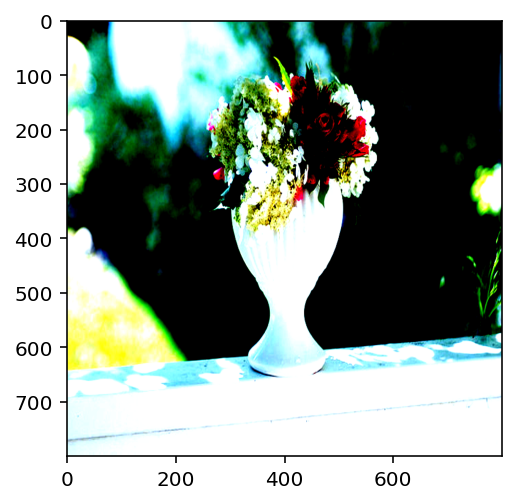

In [43]:
plt.imshow(img.permute(1,2,0))

In [31]:
while 1:
    continue

KeyboardInterrupt: ignored

In [0]:
import torch
from torch import nn

In [0]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)
output.backward()

tensor(2.7195, grad_fn=<NllLossBackward>)


In [0]:
torch.__version__

'1.5.0+cu101'

In [0]:
output.requires_grad

False

In [0]:
x = np.array([1, 2])
print(x.shape)

(2,)


In [0]:
z=np.expand_dims(x, axis=-1)
np.repeat(z,3,axis=-1).shape

(2, 3)

In [0]:
for im,q,a in data_loader:
    print(im.shape)
    print(q['ids'].shape)
    print(a.shape)
    break

In [0]:
len(answer_to_index)

162496

In [0]:
img,q,a=vqa_data[58]

In [0]:
a,b=torch.max(a.unsqueeze(0),dim = 1)

In [0]:
b.requires_grad = True

RuntimeError: ignored

In [0]:
a.unsqueeze(0).view(-1,1).shape


torch.Size([162496, 1])

In [0]:
bert_config = BertConfig(hidden_size=256, num_attention_heads=8, num_hidden_layers=6)
bert_decoder_config = BertConfig(is_decoder=True, hidden_size=256, num_attention_heads=8, num_hidden_layers=6)

enc_dec_config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder_config= bert_config, decoder_config= bert_decoder_config)


In [0]:
model = EncoderDecoderModel(config= enc_dec_config)

In [0]:
outputs = model(input_ids = q['ids'].unsqueeze(0), decoder_inputs_embeds = h[0].unsqueeze(0).flatten(2).permute(2, 0, 1))

In [0]:
outputs[2].shape

In [0]:
bert_decoder = BertModel(config  = bert_decoder_config)
outputs = bert_decoder(input_ids = q['ids'].unsqueeze(0), encoder_hidden_states = h[0].unsqueeze(0).flatten(2).permute(0,2,1))

In [0]:
outputs = bert_decoder(input_ids = q['ids'].unsqueeze(0), encoder_hidden_states = h[0].unsqueeze(0).flatten(2).permute(0,2,1))

In [0]:
while 1 :
    continue

In [0]:
BertModel??

In [0]:
 h[0].unsqueeze(0).flatten(2).permute(0, 2, 1).shape

In [0]:
q['ids'].unsqueeze(0).shape